In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
from ast import literal_eval
import re
import pickle
import numpy.linalg as la
import collections
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn import svm
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

# Load embeddings and align classes

In [2]:
embeddings = h5py.File('embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
irmas/yamnet
irmas/yamnet/features
irmas/yamnet/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys
openmic/yamnet
openmic/yamnet/features
openmic/yamnet/keys


In [3]:
with open('class-map-10.json', 'r') as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
class_map

{'cello': 3,
 'clarinet': 4,
 'flute': 7,
 'guitar': 8,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'trumpet': 16,
 'violin': 18,
 'voice': 19}

In [4]:
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

In [5]:
# use a Pandas DataFrame to record all results and save into a csv file later
result_all = pd.DataFrame({'instrument': [],
                          'train_set': [],
                          'test_set': [],
                          'precision': [],
                          'recall': [],
                          'f1-score': [],
                          'support': [],
                          'accuracy': [],
                          'roc_auc': [],
                          'ap': []
                         })

In [6]:
embedding_name = 'yamnet'

# irmas->irmas

In [7]:
# irmas: Vggish embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

(33525, 1024) (33525,)
(6705,)


In [8]:
key_clip

array(['001__[gel][dru][pop_roc]0829__1',
       '001__[gel][dru][pop_roc]0829__2',
       '001__[gel][dru][pop_roc]0829__3', ..., '[voi][pop_roc]2548__1',
       '[voi][pop_roc]2548__2', '[voi][pop_roc]2548__3'], dtype=object)

In [9]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 1024) (6705,)


In [10]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

In [11]:
# these loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(str(key_clip[k])))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [12]:
#keys = np.array([str(k, encoding='utf-8') for k in key_clip])
keys = np.array(key_clip)
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [13]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

# print out the sliced shapes as a sanity check
print(X_train.shape)
print(X_test.shape)

(5039, 1024)
(1666, 1024)


In [14]:
# standardize embedding
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# kernelize embedding
feature_map_fourier = RBFSampler(n_components=4*X_train.shape[1], random_state=0)
param_grid = {'gamma': [10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)] }  
scoring = 'roc_auc'; cv = 3
Sampler = GridSearchCV(feature_map_fourier, param_grid=param_grid, cv=cv, scoring=scoring)  
Sampler.fit(X_train)
X_train = Sampler.transform(X_train)
X_test = Sampler.transform(X_test)
print(X_train.shape, X_test.shape)

print(Sampler.best_estimator_)

############################# project the LDA direction #############################
file = open('kernelize_LDA_' + embedding_name + '_coef_genre.pickle', 'rb')
globals()['LDA_coef_' + embedding_name] = pickle.load(file)
file.close()

W = globals()['LDA_coef_' + embedding_name]
U, s, V = la.svd(W, full_matrices=False)
A = np.dot(V.T, V)
print(W.shape, U.shape, s.shape, V.shape, A.shape)

X_train = X_train.dot(np.eye(len(A)) - A)
X_test = X_test.dot(np.eye(len(A)) - A)
print(X_train.shape, X_test.shape)

(5039, 4096) (1666, 4096)
RBFSampler(gamma=1e-05, n_components=4096, random_state=0)
(5, 4096) (5, 5) (5,) (5, 4096) (4096, 4096)
(5039, 4096) (1666, 4096)


In [15]:
train_set_name, test_set_name = 'irmas', 'irmas'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()  

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_train_inst = Y_true_train==instrument
    Y_true_test_inst = Y_true_test==instrument
    
    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }  
    scoring = 'f1'; cv = 3
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)  
    
    # fit the model
    clf.fit(X_train, Y_true_train_inst)
    
    # predict
    Y_pred_test_inst = clf.predict(X_test)
    
    # Get prediction scores for the positive class
    Y_pred_test_scores = clf.predict_proba(X_test)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.98      0.95      0.96      1572
        True       0.44      0.70      0.54        94

    accuracy                           0.93      1666
   macro avg       0.71      0.82      0.75      1666
weighted avg       0.95      0.93      0.94      1666

ROC-AUC = 0.927		AP = 0.622
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.99      0.88      0.93      1539
        True       0.37      0.86      0.52       127

    accuracy                           0.88      1666
   macro avg       0.68      0.87      0.72      1666
weighted avg       0.94      0.88      0.90      1666

ROC-AUC = 0.918		AP = 0.684
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.99      0.88    

# openmic->openmic

In [16]:
# openmic: vggish embedding
feature = np.array(embeddings['openmic'][embedding_name]['features'])
keys = np.array(embeddings['openmic'][embedding_name]['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)
key_clip.shape

(380000, 1024) (380000,)


(20000,)

In [17]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

#key_clip = np.array([str(k, 'utf-8') for k in key_clip])
key_clip = np.array(key_clip)
key_clip

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 1024) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype=object)

In [18]:
# key-label map using the information from the dataset source
data_root = '/import/c4dm-datasets/openmic-2018/openmic-2018/'
# Replaced the above by a local symbolic link within the github repo
# data_root = 'openmic-2018/'

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_true']
Ymask = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_mask']
sample_key = np.load(os.path.join(data_root, 'openmic-2018.npz'))['sample_key']

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

(20000, 20) (20000, 20) (20000,)


In [19]:
Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

X = feature_clip
del(feature_clip)

print(X.shape, Y_true.shape, Y_mask.shape)

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 1024) (20000, 20) (20000, 20)


In [20]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [21]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [22]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

print(X_train.shape); print(X_test.shape)

(14915, 1024)
(5085, 1024)


In [23]:
# standardize embedding
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# kernelize embedding
feature_map_fourier = RBFSampler(n_components=4*X_train.shape[1], random_state=0)
param_grid = {'gamma': [10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)] }  
scoring = 'roc_auc'; cv = 3
Sampler = GridSearchCV(feature_map_fourier, param_grid=param_grid, cv=cv, scoring=scoring)  
Sampler.fit(X_train)
X_train = Sampler.transform(X_train)
X_test = Sampler.transform(X_test)
print(X_train.shape, X_test.shape)

print(Sampler.best_estimator_)

X_train = X_train.dot(np.eye(len(A)) - A)
X_test = X_test.dot(np.eye(len(A)) - A)
print(X_train.shape, X_test.shape)

(14915, 4096) (5085, 4096)
RBFSampler(gamma=1e-05, n_components=4096, random_state=0)
(14915, 4096) (5085, 4096)


In [24]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'openmic', 'openmic'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()  

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst = X_train[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }  
    scoring = 'f1'; cv = 3
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_true_train_inst)

    # predict
    Y_pred_test_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_test_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.85      0.83      0.84       259
        True       0.81      0.83      0.82       226

    accuracy                           0.83       485
   macro avg       0.83      0.83      0.83       485
weighted avg       0.83      0.83      0.83       485

ROC-AUC = 0.912		AP = 0.888
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.91      0.64      0.75       503
        True       0.37      0.76      0.49       137

    accuracy                           0.67       640
   macro avg       0.64      0.70      0.62       640
weighted avg       0.79      0.67      0.70       640

ROC-AUC = 0.767		AP = 0.449
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.87      0.67    

# irmas->openmic

In [25]:
train_set_name, test_set_name = 'irmas', 'openmic' 

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations 
    # This is what the mask arrays are for
    test_inst = Y_mask_test[:, inst_num]

    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # evaluate the classifier 
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test_inst)
    Y_pred_test_scores =  globals()['models_'+train_set_name][instrument].predict_proba(X_test_inst)[:, 1]

    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.70      0.92      0.79       259
        True       0.85      0.54      0.66       226

    accuracy                           0.74       485
   macro avg       0.78      0.73      0.73       485
weighted avg       0.77      0.74      0.73       485

ROC-AUC = 0.882		AP = 0.851
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.86      0.71      0.78       503
        True       0.35      0.56      0.43       137

    accuracy                           0.68       640
   macro avg       0.60      0.64      0.60       640
weighted avg       0.75      0.68      0.70       640

ROC-AUC = 0.689		AP = 0.384
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.84      0.60    

# openmic->irmas

In [26]:
# irmas: vggish embedding
feature = np.array(embeddings['irmas'][embedding_name]['features'])
keys_ori = np.array(embeddings['irmas'][embedding_name]['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(33525, 1024) (33525,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 1024) (6705,)


In [27]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

key_train = np.array([k[2:-1] for k in key_train])
key_test = np.array([k[2:-1]  for k in key_test])

idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [28]:
#keys = np.array([str(k, 'utf-8') for k in key_clip])
keys = np.array(key_clip)
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [29]:
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

print(X_train.shape)
print(X_test.shape)

(5039, 1024)
(1666, 1024)


In [30]:
# standardize embedding
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# kernelize embedding
feature_map_fourier = RBFSampler(n_components=4*X_train.shape[1], random_state=0)
param_grid = {'gamma': [10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)] }  
scoring = 'roc_auc'; cv = 3
Sampler = GridSearchCV(feature_map_fourier, param_grid=param_grid, cv=cv, scoring=scoring)  
Sampler.fit(X_train)
X_train = Sampler.transform(X_train)
X_test = Sampler.transform(X_test)
print(X_train.shape, X_test.shape)

print(Sampler.best_estimator_)

X_train = X_train.dot(np.eye(len(A)) - A)
X_test = X_test.dot(np.eye(len(A)) - A)
print(X_train.shape, X_test.shape)

(5039, 4096) (1666, 4096)
RBFSampler(gamma=1e-05, n_components=4096, random_state=0)
(5039, 4096) (1666, 4096)


In [31]:
train_set_name, test_set_name = 'openmic', 'irmas' 

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_test_inst = Y_true_test==instrument

    # evaluate the classifier
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test)
    Y_pred_test_scores =  globals()['models_'+train_set_name][instrument].predict_proba(X_test)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.99      0.86      0.92      1572
        True       0.26      0.79      0.39        94

    accuracy                           0.86      1666
   macro avg       0.62      0.83      0.65      1666
weighted avg       0.94      0.86      0.89      1666

ROC-AUC = 0.887		AP = 0.603
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.98      0.89      0.93      1539
        True       0.35      0.72      0.47       127

    accuracy                           0.88      1666
   macro avg       0.66      0.81      0.70      1666
weighted avg       0.93      0.88      0.90      1666

ROC-AUC = 0.880		AP = 0.596
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.98      0.77    

# Plot result on each instrument

In [32]:
# save all result into a csv file
result_all.to_csv('YAMnet_crossdataset_result_kernelLDA_genre.csv', index=False)

In [33]:
# check the PRF averaged over all instruments for each case:

train_irmas = result_all[result_all['train_set']=='irmas']
train_openmic = result_all[result_all['train_set']=='openmic']

irmas_irmas = train_irmas[train_irmas['test_set']=='irmas']
irmas_openmic = train_irmas[train_irmas['test_set']=='openmic']
openmic_openmic = train_openmic[train_openmic['test_set']=='openmic']
openmic_irmas = train_openmic[train_openmic['test_set']=='irmas']

print('PRF and accuracy of Vggish averaged over all instruments for each case:')
print('openmic->openmic:{}'.format(list(openmic_openmic[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('irmas->openmic:{}'.format(list(irmas_openmic[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('irmas->irmas:{}'.format(list(irmas_irmas[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('openmic->irmas:{}'.format(list(openmic_irmas[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))

PRF and accuracy of Vggish averaged over all instruments for each case:
openmic->openmic:[0.76, 0.83, 0.78, 0.83, 0.9, 0.83]
irmas->openmic:[0.74, 0.73, 0.73, 0.78, 0.85, 0.79]
irmas->irmas:[0.52, 0.84, 0.64, 0.91, 0.94, 0.75]
openmic->irmas:[0.33, 0.69, 0.43, 0.83, 0.84, 0.53]


In [34]:
# save the result of VGGish, yamnet, and OpenL3 into one csv file

vggish = pd.read_csv('VGGish_crossdataset_result_kernelize.csv')
openl3 = pd.read_csv('OpenL3_crossdataset_result_kernelize.csv')
yamnet = pd.read_csv('YAMnet_crossdataset_result_kernelize.csv')

# add embedding information, concatenate result
vggish['embedding'] = ['vggish'] * len(vggish['instrument'])
openl3['embedding'] = ['openl3'] * len(openl3['instrument'])
yamnet['embedding'] = ['yamnet'] * len(openl3['instrument'])

result_all_conca = pd.concat([vggish, openl3, yamnet], ignore_index=True)

# move embedding to the first column
cols = ['embedding', 'instrument', 'train_set', 'test_set', 'precision', 'recall', 'f1-score', 'support', 'accuracy', 'roc_auc', 'ap']
result_all_conca =result_all_conca[cols]

result_all_conca.to_csv('crossdataset_generalization_result_kernelize.csv', index=False)

In [35]:
# save the result of VGGish, yamnet, and OpenL3 into one csv file

vggish = pd.read_csv('VGGish_crossdataset_result_kernelLDA.csv')
openl3 = pd.read_csv('OpenL3_crossdataset_result_kernelLDA.csv')
yamnet = pd.read_csv('YAMnet_crossdataset_result_kernelLDA.csv')

# add embedding information, concatenate result
vggish['embedding'] = ['vggish'] * len(vggish['instrument'])
openl3['embedding'] = ['openl3'] * len(openl3['instrument'])
yamnet['embedding'] = ['yamnet'] * len(openl3['instrument'])

result_all_conca = pd.concat([vggish, openl3, yamnet], ignore_index=True)

# move embedding to the first column
cols = ['embedding', 'instrument', 'train_set', 'test_set', 'precision', 'recall', 'f1-score', 'support', 'accuracy', 'roc_auc', 'ap']
result_all_conca =result_all_conca[cols]

result_all_conca.to_csv('crossdataset_generalization_result_kernelLDA.csv', index=False)

In [36]:
# save the result of VGGish, yamnet, and OpenL3 into one csv file

vggish = pd.read_csv('VGGish_crossdataset_result_kernelLDA_genre.csv')
openl3 = pd.read_csv('OpenL3_crossdataset_result_kernelLDA_genre.csv')
yamnet = pd.read_csv('YAMnet_crossdataset_result_kernelLDA_genre.csv')

# add embedding information, concatenate result
vggish['embedding'] = ['vggish'] * len(vggish['instrument'])
openl3['embedding'] = ['openl3'] * len(openl3['instrument'])
yamnet['embedding'] = ['yamnet'] * len(openl3['instrument'])

result_all_conca = pd.concat([vggish, openl3, yamnet], ignore_index=True)

# move embedding to the first column
cols = ['embedding', 'instrument', 'train_set', 'test_set', 'precision', 'recall', 'f1-score', 'support', 'accuracy', 'roc_auc', 'ap']
result_all_conca =result_all_conca[cols]

result_all_conca.to_csv('crossdataset_generalization_result_kernelLDA_genre.csv', index=False)

In [40]:
df1 = pd.read_csv('crossdataset_generalization_result_kernelize.csv')
df2 = pd.read_csv('crossdataset_generalization_result_kernelLDA.csv')
df3 = pd.read_csv('crossdataset_generalization_result_kernelLDA_genre.csv')
df1['embedding'] = ['vggish-k'] * 40 + ['openl3-k'] * 40 + ['yamnet-k'] * 40 
df2['embedding'] = ['vggish-klda'] * 40 + ['openl3-klda'] * 40 + ['yamnet-klda'] * 40 
df3['embedding'] = ['vggish-klda-genre'] * 40 + ['openl3-klda-genre'] * 40 + ['yamnet-klda-genre'] * 40

df = df1.append(df2).append(df3)
df.to_csv('crossdataset_generalization_result_allcompare.csv')
df

,embedding,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap
0,vggish-k,cello,irmas,irmas,0.301887,0.851064,0.445682,94.0,0.880552,0.942017,0.626512
1,vggish-k,clarinet,irmas,irmas,0.256790,0.818898,0.390977,127.0,0.805522,0.891125,0.481053
2,vggish-k,flute,irmas,irmas,0.334483,0.801653,0.472019,121.0,0.869748,0.908503,0.622304
3,vggish-k,guitar,irmas,irmas,0.620690,0.832370,0.711111,346.0,0.859544,0.931869,0.829357
4,vggish-k,organ,irmas,irmas,0.456338,0.931034,0.612476,174.0,0.876951,0.968714,0.762779
...,...,...,...,...,...,...,...,...,...,...,...
115,yamnet-klda-genre,piano,openmic,irmas,0.263982,0.694118,0.382496,170.0,0.771309,0.840803,0.603779
116,yamnet-klda-genre,saxophone,openmic,irmas,0.263305,0.626667,0.370809,150.0,0.808523,0.817502,0.346659
117,yamnet-klda-genre,trumpet,openmic,irmas,0.383838,0.760000,0.510067,150.0,0.868547,0.899529,0.577094
118,yamnet-klda-genre,violin,openmic,irmas,0.297806,0.664336,0.411255,143.0,0.836735,0.828348,0.384526


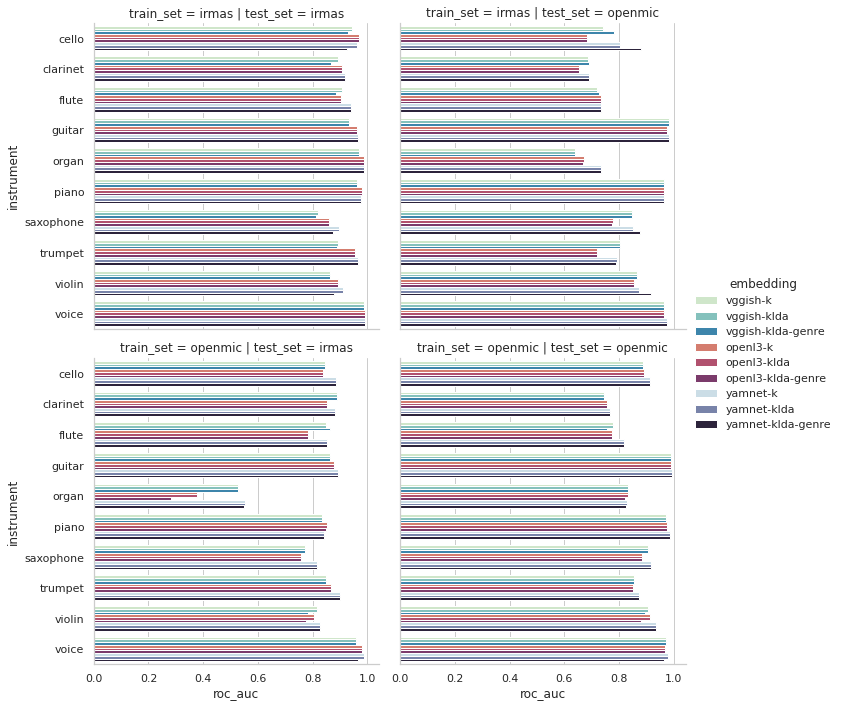

In [44]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')
diverging_colors = sns.color_palette("GnBu", 3) + sns.color_palette("flare", 3) + \
                   sns.color_palette("ch:s=.25,rot=-.25", 3) 
hue_order=['vggish-k', 'vggish-klda', 'vggish-klda-genre', 'openl3-k', 'openl3-klda', 'openl3-klda-genre',
          'yamnet-k', 'yamnet-klda', 'yamnet-klda-genre']

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            hue_order=hue_order, palette=diverging_colors);

plt.savefig('crossdataset_generalization_auc_kernelLDA_genre.png')

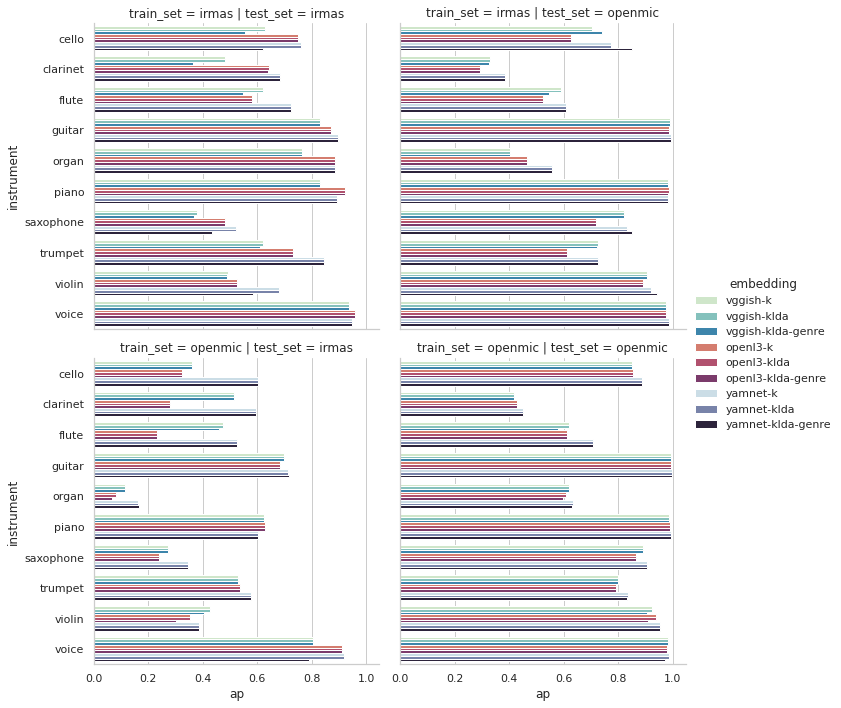

In [45]:
sns.set_theme(context='notebook', style='whitegrid')
diverging_colors = sns.color_palette("GnBu", 3) + sns.color_palette("flare", 3) + \
                   sns.color_palette("ch:s=.25,rot=-.25", 3) 
hue_order=['vggish-k', 'vggish-klda', 'vggish-klda-genre', 'openl3-k', 'openl3-klda', 'openl3-klda-genre',
          'yamnet-k', 'yamnet-klda', 'yamnet-klda-genre']

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='ap', hue='embedding', kind='bar', 
            hue_order=hue_order, palette=diverging_colors);

plt.savefig('crossdataset_generalization_ap_kernelLDA_genre.png')

In [55]:
df1 = pd.read_csv('crossdataset_generalization_result.csv')
df2 = pd.read_csv('crossdataset_generalization_result_LDAproj.csv')
df3 = pd.read_csv('crossdataset_generalization_result_LDAproj_genre.csv')
df1['embedding'] = ['vggish'] * 40 + ['openl3'] * 40 + ['yamnet'] * 40 
df2['embedding'] = ['vggish-lda'] * 40 + ['openl3-lda'] * 40 + ['yamnet-lda'] * 40 
df3['embedding'] = ['vggish-lda-genre'] * 40 + ['openl3-lda-genre'] * 40 + ['yamnet-lda-genre'] * 40

df = df1.append(df2).append(df3)
df.to_csv('crossdataset_generalization_result_allcompare.csv', index=False)#
df

,embedding,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap
0,vggish,cello,irmas,irmas,0.296703,0.861702,0.441417,94.0,0.876951,0.924429,0.613141
1,vggish,clarinet,irmas,irmas,0.302469,0.771654,0.434590,127.0,0.846939,0.879930,0.534409
2,vggish,flute,irmas,irmas,0.309764,0.760331,0.440191,121.0,0.859544,0.891979,0.612665
3,vggish,guitar,irmas,irmas,0.662005,0.820809,0.732903,346.0,0.875750,0.934091,0.825267
4,vggish,organ,irmas,irmas,0.506494,0.896552,0.647303,174.0,0.897959,0.956881,0.706318
...,...,...,...,...,...,...,...,...,...,...,...
115,yamnet-lda-genre,piano,openmic,irmas,0.197623,0.782353,0.315540,170.0,0.653661,0.818921,0.527044
116,yamnet-lda-genre,saxophone,openmic,irmas,0.205769,0.713333,0.319403,150.0,0.726291,0.807256,0.329186
117,yamnet-lda-genre,trumpet,openmic,irmas,0.259188,0.893333,0.401799,150.0,0.760504,0.911381,0.662541
118,yamnet-lda-genre,violin,openmic,irmas,0.192177,0.790210,0.309166,143.0,0.696879,0.821979,0.353772


In [56]:
df0 = pd.read_csv('crossdataset_generalization_result_allcompare.csv')

In [57]:
df1 = pd.read_csv('crossdataset_generalization_result_kernelize.csv')
df2 = pd.read_csv('crossdataset_generalization_result_kernelLDA.csv')
df3 = pd.read_csv('crossdataset_generalization_result_kernelLDA_genre.csv')
df1['embedding'] = ['vggish-k'] * 40 + ['openl3-k'] * 40 + ['yamnet-k'] * 40 
df2['embedding'] = ['vggish-klda'] * 40 + ['openl3-klda'] * 40 + ['yamnet-klda'] * 40 
df3['embedding'] = ['vggish-klda-genre'] * 40 + ['openl3-klda-genre'] * 40 + ['yamnet-klda-genre'] * 40

df = df1.append(df2).append(df3)
df.to_csv('crossdataset_generalization_result_allcompare_kLDA.csv', index=False)#

In [59]:
df = df0.append(df)
df

,embedding,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap
0,vggish,cello,irmas,irmas,0.296703,0.861702,0.441417,94.0,0.876951,0.924429,0.613141
1,vggish,clarinet,irmas,irmas,0.302469,0.771654,0.434590,127.0,0.846939,0.879930,0.534409
2,vggish,flute,irmas,irmas,0.309764,0.760331,0.440191,121.0,0.859544,0.891979,0.612665
3,vggish,guitar,irmas,irmas,0.662005,0.820809,0.732903,346.0,0.875750,0.934091,0.825267
4,vggish,organ,irmas,irmas,0.506494,0.896552,0.647303,174.0,0.897959,0.956881,0.706318
...,...,...,...,...,...,...,...,...,...,...,...
115,yamnet-klda-genre,piano,openmic,irmas,0.263982,0.694118,0.382496,170.0,0.771309,0.840803,0.603779
116,yamnet-klda-genre,saxophone,openmic,irmas,0.263305,0.626667,0.370809,150.0,0.808523,0.817502,0.346659
117,yamnet-klda-genre,trumpet,openmic,irmas,0.383838,0.760000,0.510067,150.0,0.868547,0.899529,0.577094
118,yamnet-klda-genre,violin,openmic,irmas,0.297806,0.664336,0.411255,143.0,0.836735,0.828348,0.384526
